In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


In [2]:
infection = pd.read_csv("https://richardson.byu.edu/220/infection.csv")
infection.head(5)

,InfctRsk,Age,Stay,MedSchool,Region,Beds
0,4.1,55.7,7.13,No,west,279
1,1.6,58.2,8.82,No,north-central,80
2,2.7,56.9,8.34,No,south,107
3,5.6,53.7,8.95,No,west,147
4,5.7,56.5,11.20,No,north-east,180


In [5]:
# infection.to_csv("infection.csv", index=False)

Regression Analysis

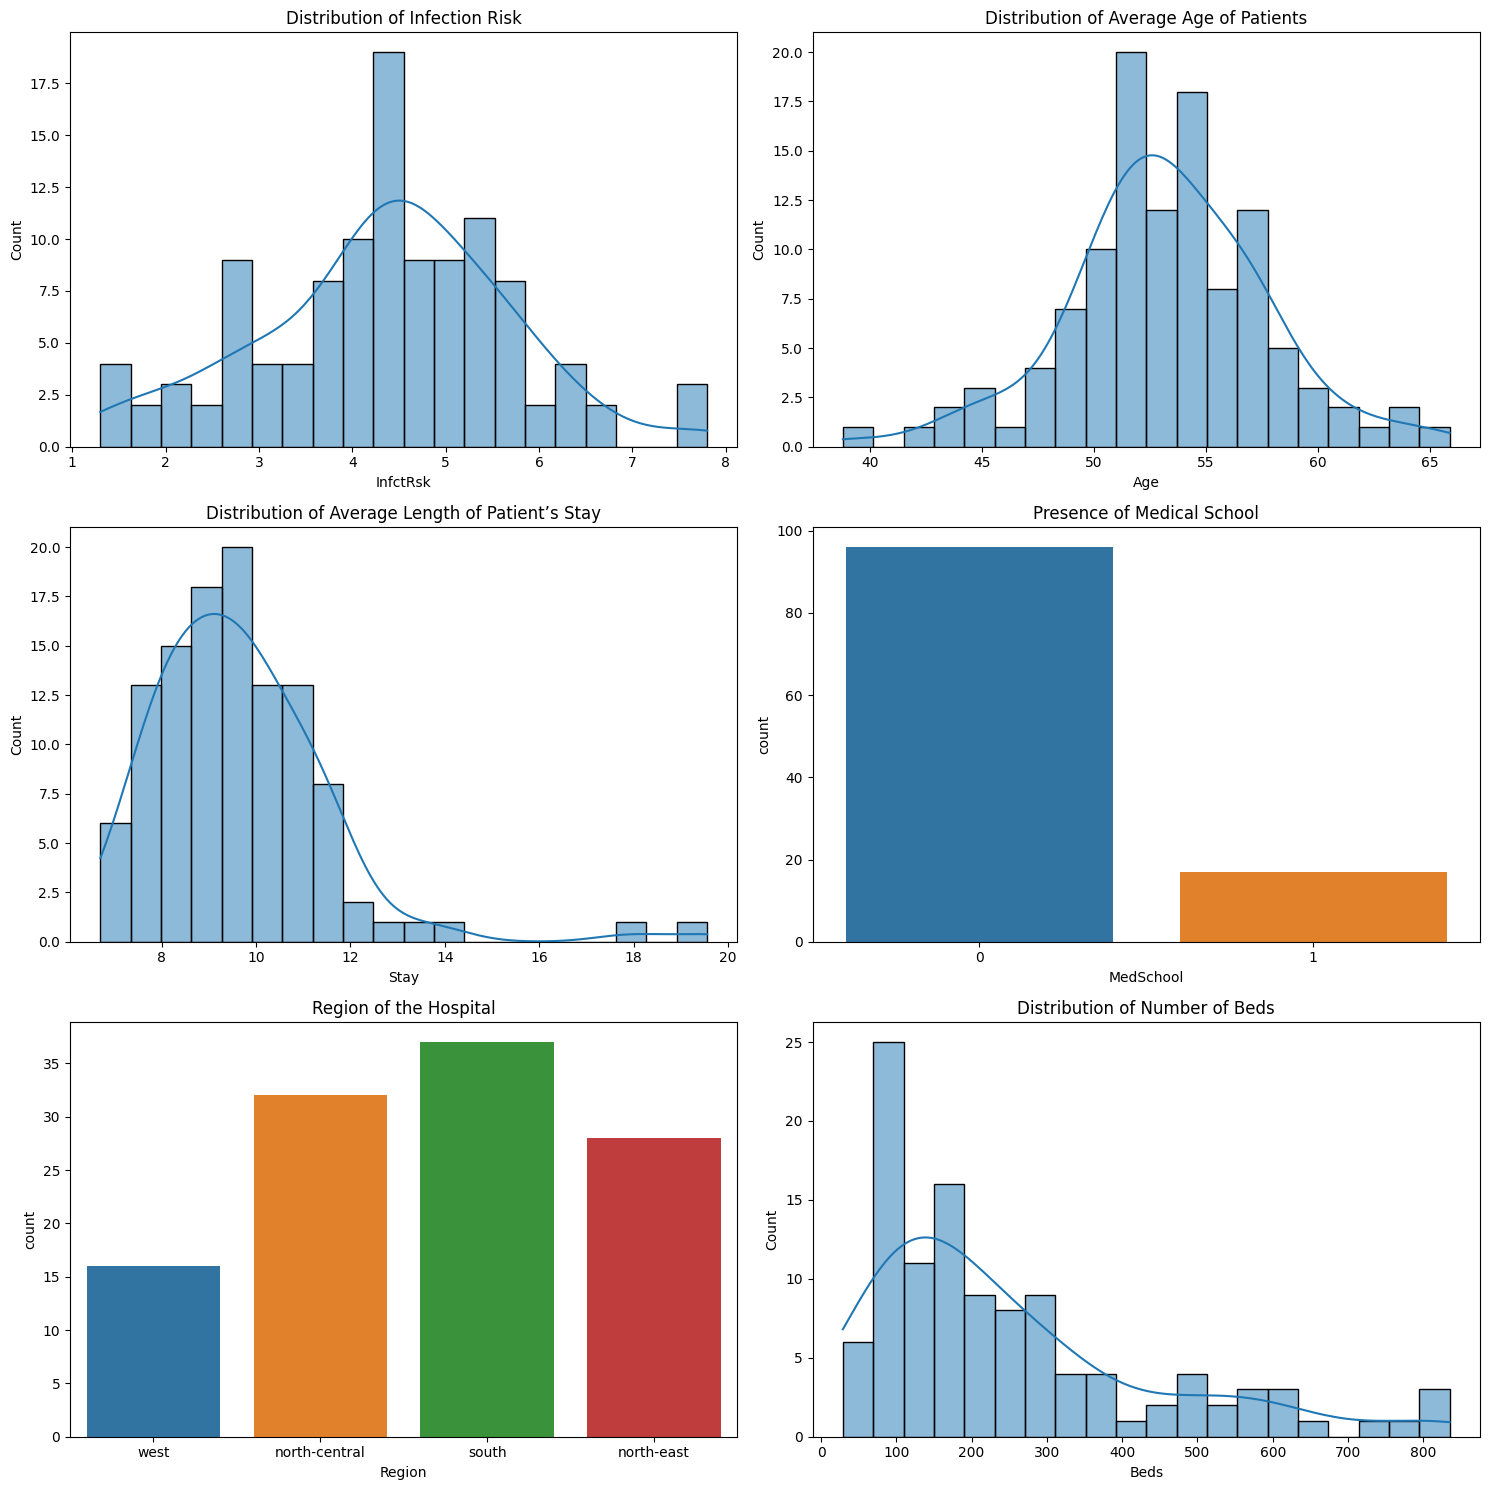

In [6]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plotting for 'InfctRsk'
sns.histplot(infection['InfctRsk'], bins=20, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Infection Risk')

# Plotting for 'Age'
sns.histplot(infection['Age'], bins=20, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of Average Age of Patients')

# Plotting for 'Stay'
sns.histplot(infection['Stay'], bins=20, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of Average Length of Patient’s Stay')

# Plotting for 'MedSchool'
sns.countplot(x='MedSchool', data=infection, ax=axs[1, 1])
axs[1, 1].set_title('Presence of Medical School')

# Plotting for 'Region'
sns.countplot(x='Region', data=infection, ax=axs[2, 0])
axs[2, 0].set_title('Region of the Hospital')

# Plotting for 'Beds'
sns.histplot(infection['Beds'], bins=20, kde=True, ax=axs[2, 1])
axs[2, 1].set_title('Distribution of Number of Beds')

plt.tight_layout()
plt.show()


In [4]:
infection['MedSchool'] = infection['MedSchool'].map({'Yes': 1, 'No': 0})

In [7]:
region_dummies = pd.get_dummies(infection['Region'], drop_first=True)

# Concatenate the original DataFrame with the dummy variables for 'Region'
df_with_dummies = pd.concat([infection.drop('Region', axis=1), region_dummies], axis=1)

# Define predictor variables (X) and the target variable (y)
X = df_with_dummies.drop('InfctRsk', axis=1)
y = df_with_dummies['InfctRsk']

reg_model = LinearRegression()
reg_model.fit(X, y)

intercept = reg_model.intercept_
coefficients = reg_model.coef_

print("Intercept:", intercept)
print("Age Coefficient:", coefficients[0])
print("Stay Coefficient:", coefficients[1])
print("MedSchool Coefficient:", coefficients[2])
print("Beds Coefficient:", coefficients[3])
print("Region north-east Coefficient:", coefficients[4])
print("Region south Coefficient:", coefficients[5])
print("Region west Coefficient:", coefficients[6])

Intercept: 1.9299697372026716
Age Coefficient: -0.028863110839644268
Stay Coefficient: 0.3745462750605927
MedSchool Coefficient: -0.22869224020761542
Beds Coefficient: 0.001367342634471691
Region north-east Coefficient: 0.02992040559487469
Region south Coefficient: -0.2219935236138976
Region west Coefficient: 0.7237069314050524


Based on the results of the coefficents and taking the north-central region as base.
- the region north-east has 0.03 highier infection risk than the north-central region. assuming we hold all other variables constant
- the region south does 0.222 lower infection risk than the north-central region. assuming we hold all other variables constant
- the region west does 0.724 better infection risk than the north-central region. assuming we hold all other variables constant

Bayesian Regression

In [8]:
!pip install bambi
import bambi as bmb
import arviz as az

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 4.7 MB/s eta 0:00:00


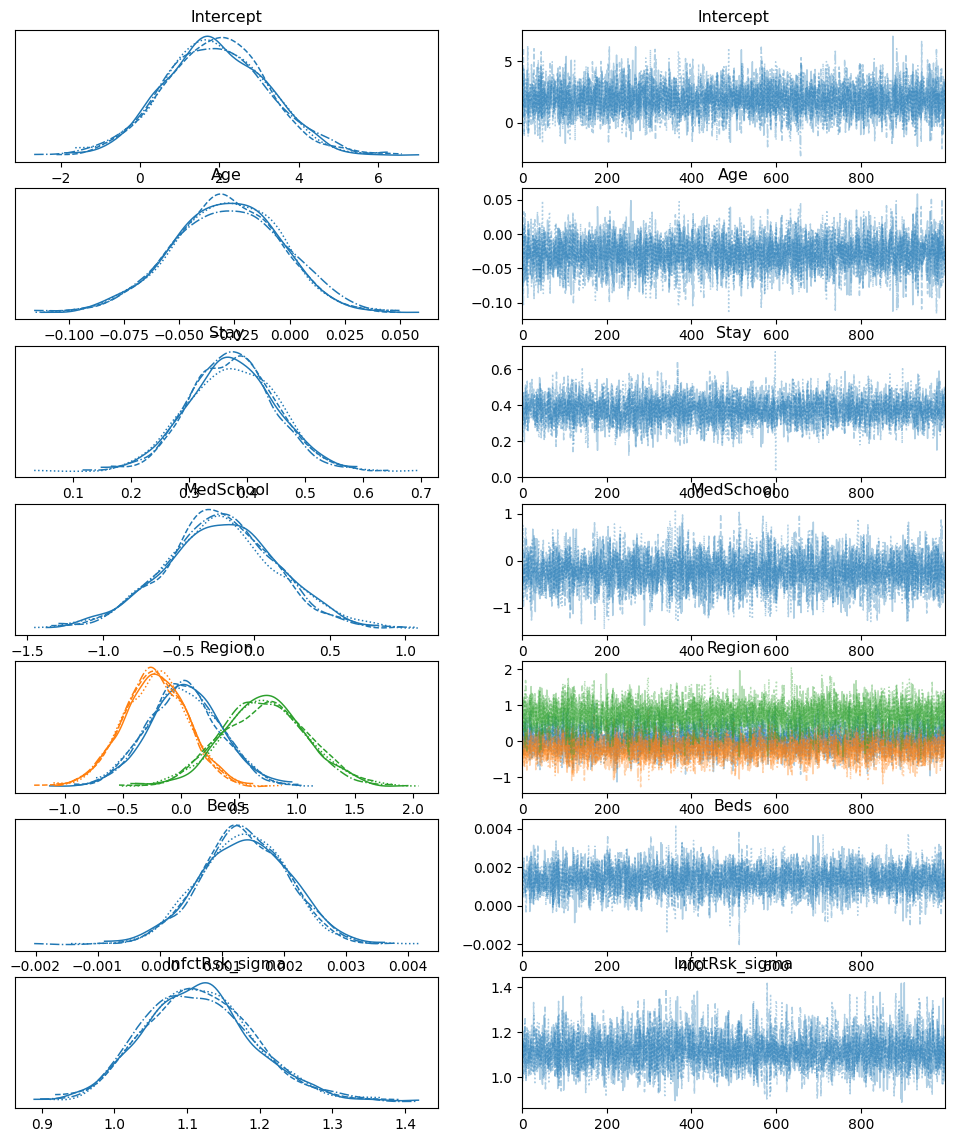

In [9]:
model = bmb.Model('InfctRsk ~ Age + Stay + MedSchool + Region + Beds', infection)
results = model.fit(draws=1000, chains=4)

az.plot_trace(results)
plt.show()


In [10]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.914,1.300,-0.441,4.436,0.016,0.014,6400.0,3448.0,1.0
Age,-0.029,0.025,-0.075,0.018,0.000,0.000,6543.0,3284.0,1.0
Stay,0.374,0.074,0.235,0.511,0.001,0.001,5142.0,3372.0,1.0
MedSchool,-0.226,0.372,-0.898,0.503,0.005,0.005,5010.0,2671.0,1.0
Region[north-east],0.031,0.311,-0.547,0.621,0.005,0.004,4476.0,3500.0,1.0
Region[south],-0.221,0.277,-0.736,0.309,0.004,0.003,4104.0,3484.0,1.0
Region[west],0.717,0.364,0.047,1.403,0.006,0.004,4239.0,3187.0,1.0
Beds,0.001,0.001,0.000,0.003,0.000,0.000,5415.0,3664.0,1.0
InfctRsk_sigma,1.117,0.077,0.981,1.266,0.001,0.001,5201.0,3240.0,1.0


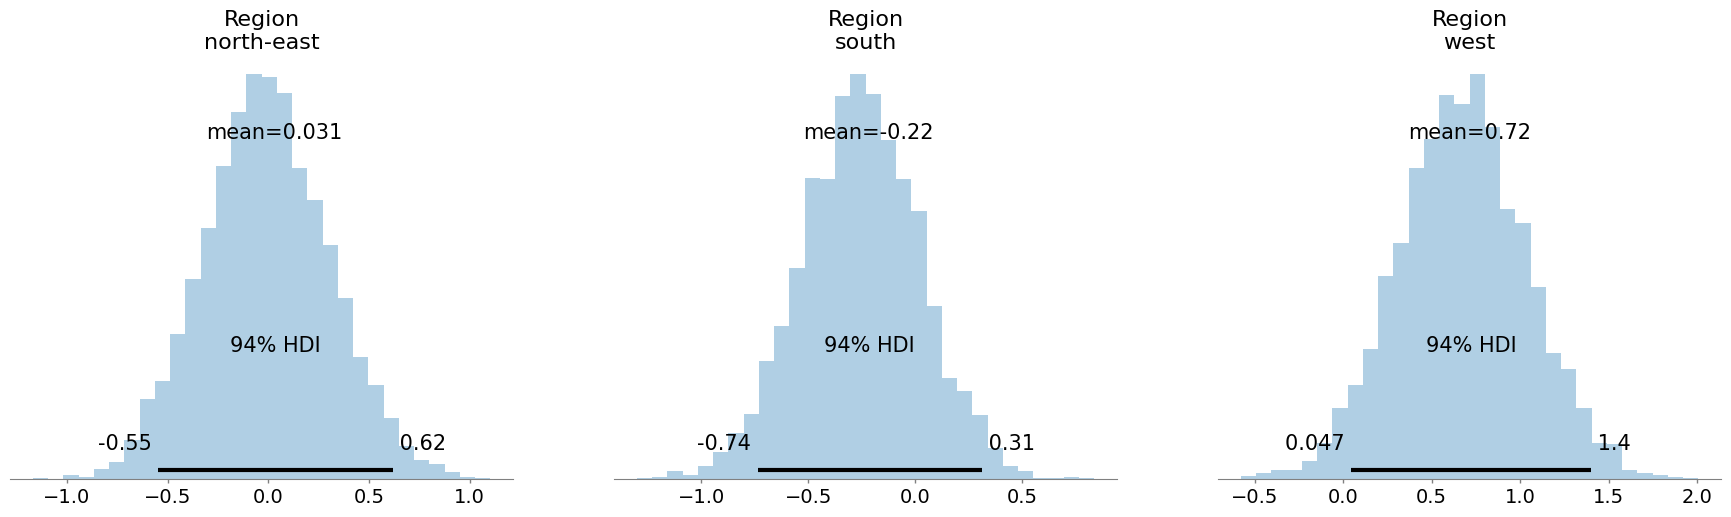

In [11]:
az.plot_posterior(results, var_names=['Region'], coords={'Region_dim': ['north-east', 'south', 'west']},
                  kind='hist', bins=30)

plt.show()


In [12]:
# Extract and reshape the posterior samples for 'Region'
region_samples = results.posterior['Region'].values.reshape(-1, 3)

# Calculate probabilities
prob_positive = np.mean(region_samples > 0, axis=0)
prob_negative = np.mean(region_samples < 0, axis=0)

# Print results
for label, pos, neg in zip(['north-east', 'south', 'west'], prob_positive, prob_negative):
    print(f"For {label}: Probability Positive = {pos:.4f}, Probability Negative = {neg:.4f}")


For north-east: Probability Positive = 0.5333, Probability Negative = 0.4667
For south: Probability Positive = 0.2140, Probability Negative = 0.7860
For west: Probability Positive = 0.9768, Probability Negative = 0.0232


### Discussion
1. Why was it pivotal to incorporate variables like "Age", "Stay", "MedSchool", and "Beds" in the model, even though the focal interest was `Region'? <br>
To remove confusion. The inclusion of other variables confirms that the effects attributed to "Region" are indeed because of regional differences and not confounded by these other variables. <br>
Adding them also increases the accuracy of the prediction since the model is being fed more information in general. <br>
<br>
2. Differentiate between the Bayesian approach and the traditional regression approach. Enumerate the advantages and potential limitations of deploying Bayesian regression in this context. <br>
Traditional regression provides point estimates for model parameters and uses frequentist statistics to assess the reliability of these estimates.As for the Bayesian approach, it gives a full probability distribution over model parameters, allowing for a more nuanced understanding of uncertainty.<br><br>
Advantages of Bayesian Regression is that it provides a full posterior distribution, helping us understand the range of possible values a parameter can take. It also incorporates prior knowledge into the model, which can be useful in samll data set. <br><br>
Potential limitaions include computational cost, subjectivity of priors, interpretability. Bayesian models can be computationally intensive, especially for large datasets or complex models. Choosing a prior can affect the results by introducing a subjective elemnt into the analysis. Finally, the results can sometimes be more challenging to interpret especially for those not familiar with Bayesian methods.







